In [1]:
%matplotlib inline
import sys
from scipy import stats
from collections import defaultdict, Counter
import networkx as nx
import numpy as np
import pylab as plt
import math
#import matplotlib.cm as cm
import statsmodels.api as sm
from os import listdir
from scipy.stats.stats import pearsonr
import json
import random
import itertools
from copy import deepcopy
import time
import scipy as sp
from scipy.sparse import csr_matrix
import matplotlib.cm as cm
from numpy.random import choice
import itertools
from sklearn import manifold
from matplotlib import collections  as mc
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from numpy.random import choice
import matplotlib.patches as patches
import copy

# flush print
def flushPrint(d):
    sys.stdout.write('\r')
    sys.stdout.write('%d' % d)
    sys.stdout.flush()

def OLSRegressFit(x,y):
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant, beta = res.params
    return constant, beta
    

# Generate data

In [40]:
data=[]
dataLen = 100
for j in range(dataLen):
    pos1 = choice([0,1], p=[0.2,0.8])
    if pos1 == 1 and np.random.uniform()<0.9:
        pos3=1
    else:
        pos3=0
    pos2 = choice([0,1], p=[0.9,0.1])
    pos4 = choice([0,1], p=[0.9,0.1])
    pos5 = choice([0,1], p=[0.9,0.1])
    pos6 = choice([0,1], p=[0.9,0.1])
    data.append([pos1,pos2,pos3,pos4,pos5,pos6])

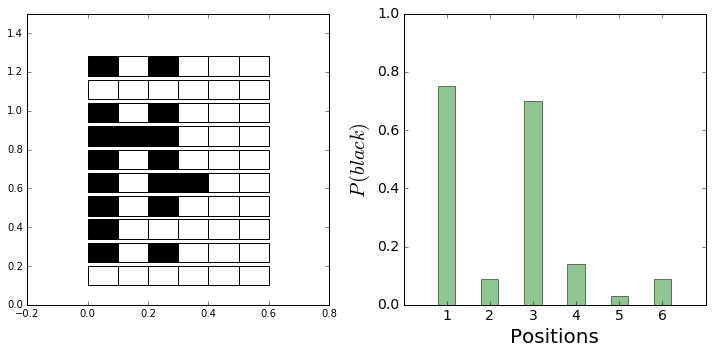

In [45]:

# visualize data
fig = plt.figure(figsize=(10, 5),facecolor='white')
ax = fig.add_subplot(121)
for i in range(10):
    for j in range(len(data[0])):
        centerX,centerY=(j * 0.1, 0.1+i/10.0+i*0.02)
        width,height=(0.1,0.1)
        if data[i][j]==0:
                   f=False
        else:
                   f=True
        ax.add_patch(patches.Rectangle((centerX,centerY),width,height,fill=f,facecolor='k'))
plt.xlim(-0.2,0.8)
plt.ylim(0,1.5)
#
ax = fig.add_subplot(122)
plt.bar(range(6),[i.count(1)/float(N) for i in zip(*data)],\
        align='center', alpha=0.5,width=0.4,color='ForestGreen')
plt.xticks(range(6), [1,2,3,4,5,6])
plt.xlabel('Positions',fontsize=20)
plt.ylabel(r'$P\,(black)$',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.ylim(0,1)
    
#
plt.tight_layout()

# Boltzmann machine and its negative phase

In [55]:
# initialize

n_v = 6
n_h = 2
n_nodes=n_v+n_h
bound = 0.1 * np.sqrt(float(len(data)) / n_nodes)
S=np.random.randint(2,size=n_nodes) # nodes states (0/1)
B=np.random.uniform(low=-bound,high=bound,size=n_nodes) # nodes bias
W = np.random.uniform(low=-bound,high=bound,size=(n_nodes, n_nodes)) # edge weights
W = (W + W.T)/2
T = 1

# calculate energy
E=0
E-=sum(S*B)
for i in range(n_nodes):
    for j in range(n_nodes):
        if i<j:
            E-=W[i,j]*S[i]*S[j]

# thermal equilibrium 
N=int(1e5)
K = np.random.randint(n_nodes,size=N) # random choiced nodes to be flipped
ET=[E]
ST=[list(S)]
for k in K:
    # calculate the magnitude of energy relevant to the chosen node
    a = list(W[k]*S)
    a.pop(k)
    de = sum(a)+B[k]
    # determine the sign
    if S[k]==1:
        de = de
    if S[k]==0:
        de = -de    
    pFlip = 1.0/(1+np.exp(de)/T)
    if  np.random.uniform() < pFlip:
        E += de
        S[k]=1-S[k] 
    ET.append(E)
    ST.append(list(S))
        

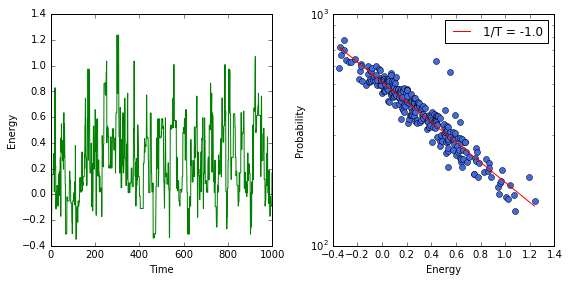

In [58]:
fig = plt.figure(figsize=(8, 4),facecolor='white')
ax = fig.add_subplot(121)
plt.plot(ET[-1000:],'g-')
plt.xlabel('Time')
plt.ylabel('Energy')
#
#
ax = fig.add_subplot(122)
cc=Counter([np.round(i,4) for i in ET])
x,y=np.array(sorted(cc.items())).T
plt.plot(x,y,'o',color='RoyalBlue',alpha=1)
constant,beta = OLSRegressFit(x,np.log(y))
xs=np.linspace(min(x),max(x),100)
plt.plot(xs,np.exp(constant+xs*beta),'r-',label='1/T = '+str(np.round(beta,2)))
plt.yscale('log')
plt.legend(loc=1)
plt.xlabel('Energy')
plt.ylabel('Probability')
#
plt.tight_layout()

# compare phases 

In [64]:
rdata=[1, 0, 1, 0, 0, 0]#example data
Nsimu=int(1e5)#number of simulations
K = np.random.randint(n_v,n_nodes,size=Nsimu) # random chosen nodes to be flipped
S = np.array(rdata+list(np.random.randint(2,size=n_h))) # newly generated visible states
E = 0
E -= sum(S*B)
for i in range(n_nodes):
    for j in range(n_nodes):
        if i<j:
            E-=W[i,j]*S[i]*S[j]
ET=[E]
ST=[list(S)]          
            
# thermal equilibrium 
for k in K:
    # calculate the magnitude of energy relevant to the chosen node
    a = list(W[k]*S)
    a.pop(k)
    de = sum(a)+B[k]
    # determine the sign
    if S[k]==1:
        de = de
    if S[k]==0:
        de = -de    
    pFlip = 1.0/(1+np.exp(de)/T)
    if  np.random.uniform() < pFlip:
        E += de
        S[k]=1-S[k] 
    ET.append(E)
    ST.append(list(S))

    
Pn = [Counter(k)[1]/float(len(k)) for k in zip(*ST)]
Pe = {}
TST = np.array(ST).T
for i in range(n_nodes):
    for j in range(n_nodes):
        if j>i:
            k=TST[i]*TST[j]
            Pe[(i,j)]=Counter(k)[1]/float(len(k))
            


In [68]:
# thermal equilibrium for negative phase
N=int(1e5)
K = np.random.randint(n_nodes,size=N) # random choiced nodes to be flipped
ST=[list(S)]
for k in K:
    # calculate the magnitude of energy relevant to the chosen node
    a = list(W[k]*S)
    a.pop(k)
    de = sum(a)+B[k]
    # determine the sign
    if S[k]==1:
        de = de
    if S[k]==0:
        de = -de    
    pFlip = 1.0/(1+np.exp(de)/T)
    if  np.random.uniform() < pFlip:
        S[k]=1-S[k] 
    ST.append(list(S))
    
Pn_ = [Counter(k)[1]/float(len(k)) for k in zip(*ST)]
Pe_ = {}
TST = np.array(ST).T
for i in range(n_nodes):
    for j in range(n_nodes):
        if j>i:
            k=TST[i]*TST[j]
            Pe_[(i,j)]=Counter(k)[1]/float(len(k))

In [73]:
name={0:'v1',1:'v2',2:'v3',3:'v4',4:'v5',5:'v6',6:'h1',7:'h2'}
pos={'v1':(1,3),'v2':(2,2),'v3':(3,1),'v4':(4,1),'v5':(5,2),'v6':(6,3),
     'h1':(2,4),'h2':(5,4)}

In [74]:
for i in range(n_v,n_nodes):
    print(name[i],str(np.round(Pn_[i],2)),str(np.round(Pn[i],2)))

('h1', '0.42', '0.43')
('h2', '0.47', '0.47')


In [77]:
for i,j in sorted(Pe.keys()):
    if Pe[(i,j)]>0:
        print(name[i],name[j],str(np.round(Pe_[(i,j)],2)),str(np.round(Pe[(i,j)],2)))

('v1', 'v3', '0.25', '1.0')
('v1', 'h1', '0.2', '0.43')
('v1', 'h2', '0.23', '0.47')
('v3', 'h1', '0.21', '0.43')
('v3', 'h2', '0.25', '0.47')
('h1', 'h2', '0.19', '0.19')


# Training

### intitialize

In [49]:

probs=[0.95,0.01,0.01,0.01]
Ndata=int(1000)
data=[[choice([0,1], p=[1-pi,pi]) for pi in probs] for j in range(Ndata)]

n_nodes=7
n_v = 4
n_h = 3
S=np.random.randint(2,size=n_nodes) # nodes states (0/1)
B=np.random.uniform(size=n_nodes) # nodes bias
W = np.random.uniform(size=(n_nodes, n_nodes)) # edge weights
W = (W + W.T)/2


B1=np.copy(B)
W1=np.copy(W)

### training

In [50]:


def updateBM(rdata,S,B,W,learnRate,Nsimulation):
    # nagtive phase 
    K = np.random.randint(len(S),size=Nsimulation) # random choiced nodes to be flipped
    ST=[list(S)]
    for k in K:
        a = list(W[k]*S)
        a.pop(k)
        de = sum(a)+B[k]
        if S[k]==1:
            de = -de
        if de > 0:
            S[k]=1-S[k] 
            ST.append(list(S))
        else:
            pFlip = 1.0/(1+np.exp(-de)) 
            if  np.random.uniform() < pFlip:
                S[k]=1-S[k] 
                ST.append(list(S))
    ProNegNode = [Counter(k)[1]/float(len(k)) for k in zip(*ST)]
    ProNegEdge={}
    TST = np.array(ST).T
    for i in range(n_nodes):
        for j in range(n_nodes):
            if j>i:
                k=TST[i]*TST[j]
                ProNegEdge[(i,j)]=Counter(k)[1]/float(len(k))    

    #positve phase
    S[:4]=rdata
    K = np.random.randint(len(rdata),len(S),size=Nsimulation) # random choiced nodes to be flipped
    ST=[list(S)]
    for k in K:
        a = list(W[k]*S)
        a.pop(k)
        de = sum(a)+B[k]
        if S[k]==1:
            de = -de
        if de > 0:
            S[k]=1-S[k] 
            ST.append(list(S))
        else:
            pFlip = 1.0/(1+np.exp(-de)) 
            if  np.random.uniform() < pFlip:
                S[k]=1-S[k] 
                ST.append(list(S))
    ProPosNode = [Counter(k)[1]/float(len(k)) for k in zip(*ST)]
    ProPosEdge={}
    TST = np.array(ST).T
    for i in range(n_nodes):
        for j in range(n_nodes):
            if j>i:
                k=TST[i]*TST[j]
                ProPosEdge[(i,j)]=Counter(k)[1]/float(len(k))

    #update
    for i,j in ProNegEdge:
        if ProPosEdge[(i,j)]>0:
            deltaw=ProPosEdge[(i,j)]-ProNegEdge[(i,j)]
            W[i,j]+=deltaw*learnRate
            W[j,i]=W[i,j]
    for i in range(len(rdata),len(S)):
        deltab=ProPosNode[i]-ProNegNode[i]
        B[i]+=deltab*learnRate
    return S,B,W

In [51]:
rate=0.1# learning rate
Nsim=int(1e3)# MCMC to arrive thermal equiblium 
rdata=data[3]

n=0
for rdata in data:
    flushPrint(n)
    updateBM(rdata,S,B,W,rate,Nsim)
    n+=1


999

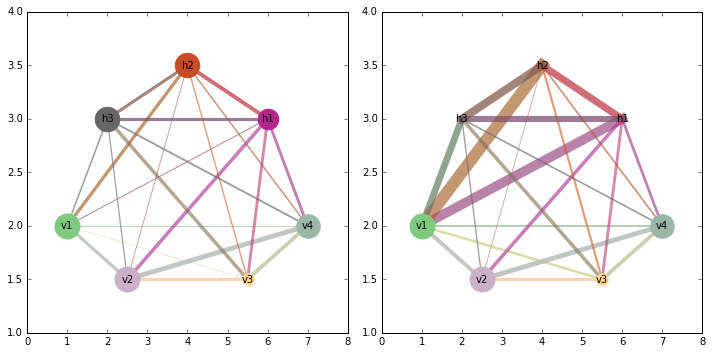

In [55]:
name={0:'v1',1:'v2',2:'v3',3:'v4',4:'h1',5:'h2',6:'h3'}
pos={'v1':(1,2),'v2':(2.5,1.5),'v3':(5.5,1.5),'v4':(7,2),'h1':(6,3),'h2':(4,3.5),'h3':(2,3)}
cmap = cm.get_cmap('Accent',7)
#
fig = plt.figure(figsize=(10, 5),facecolor='white')
ax = fig.add_subplot(121)
for k in range(len(B1)):
    label = name[k]
    xk,yk=pos[label]
    plt.scatter(xk,yk,s=1000*B1[k],zorder=2,color=cmap(k))
    plt.text(xk,yk,label,ha='center',va='center')
    for m in range(len(B1)):
        xm,ym=pos[name[m]]
        weight = W1[m,k]
        plt.plot([xk,xm],[yk,ym],color=cmap(k),linewidth=weight*5,alpha=0.5,zorder=1)
#
ax = fig.add_subplot(122)
for k in range(len(B)):
    label = name[k]
    xk,yk=pos[label]
    plt.scatter(xk,yk,s=1000*B[k],zorder=2,color=cmap(k))
    plt.text(xk,yk,label,ha='center',va='center')
    for m in range(len(B)):
        xm,ym=pos[name[m]]
        weight = W[m,k]
        plt.plot([xk,xm],[yk,ym],color=cmap(k),linewidth=weight*5,alpha=0.5,zorder=1)
#
plt.tight_layout()

In [70]:
np.round(B-B1,2)

array([ 0.  ,  0.  ,  0.  ,  0.  , -4.58, -3.37, -4.08])

In [74]:
np.round(W-W1,1)

array([[ 0. ,  0.1,  0.4,  0.2, -2.1,  1.7, -1.6],
       [ 0.1,  0. ,  0. ,  0. , -0. , -0. ,  0. ],
       [ 0.4,  0. ,  0. ,  0. , -0. ,  0.2,  0. ],
       [ 0.2,  0. ,  0. ,  0. , -0. ,  0. , -0. ],
       [-2.1, -0. , -0. , -0. ,  0. , -2.1, -1.8],
       [ 1.7, -0. ,  0.2,  0. , -2.1,  0. , -2.2],
       [-1.6,  0. ,  0. , -0. , -1.8, -2.2,  0. ]])

In [73]:
dW = W-W1
for i in range(7):
    for j in range(7):
        if np.round(dW[i,j],2)<0 and j>i:
            print (i,j,str(np.round(dW[i,j],2)))

(0, 4, '-2.08')
(0, 6, '-1.63')
(1, 5, '-0.03')
(2, 4, '-0.01')
(3, 4, '-0.03')
(3, 6, '-0.04')
(4, 5, '-2.14')
(4, 6, '-1.83')
(5, 6, '-2.17')


# generate data

In [29]:
Ngenerate = 10000
K = np.random.randint(len(S),size=Ngenerate) # random choiced nodes to be flipped
ST=[list(S)]
for k in K:
    a = list(W[k]*S)
    a.pop(k)
    de = sum(a)+B[k]
    if S[k]==1:
        de = -de
    if de > 0:
        S[k]=1-S[k] 
        ST.append(list(S))
    else:
        pFlip = 1.0/(1+np.exp(-de)) 
        if  np.random.uniform() < pFlip:
            S[k]=1-S[k] 
            ST.append(list(S))
ProNegNode = [Counter(k)[1]/float(len(k)) for k in zip(*ST)] 

In [65]:
np.round(W[0],2)

array([ 0.  ,  0.74,  0.47,  0.36, -1.9 ,  2.35, -1.34])

In [66]:
np.round(W[1],2)

array([ 0.74,  0.37,  0.61,  0.94,  0.69,  0.13,  0.26])

In [67]:
np.round(W[2],2)

array([ 0.47,  0.61,  0.49,  0.73,  0.56,  0.41,  0.69])

In [68]:
np.round(W[3],2)

array([ 0.36,  0.94,  0.73,  0.49,  0.53,  0.32,  0.32])

In [6]:
1.0/(1+np.exp(10.0))

4.5397868702434395e-05

In [7]:
1.0/(1+np.exp(0.0))

0.5

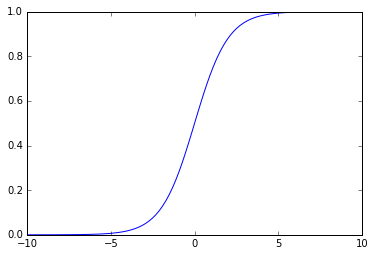

In [11]:
xs=np.linspace(-10,10,100)
plt.plot(xs,1.0/(1.0+np.exp(-xs)))

# Restricted Boltzmann Machine

#### Global energy
$E(v,h) = -(\sum\limits_k b_k v_k + \sum\limits_j c_j h_j + \sum\limits_j \sum\limits_k w_{ij}h_jv_k) = -(\textbf{b}^T \textbf{v} + \textbf{c}^T \textbf{h} + \textbf{v}^TW\textbf{h})$

In [2]:
def logistic(x): return 1.0 / (1 + np.exp(-x))

In [3]:
# from https://github.com/echen/restricted-boltzmann-machines/blob/master/rbm.py

data = np.array([[1,1,1,0,0,0],[1,0,1,0,0,0],
                 [1,1,1,0,0,0],[0,0,1,1,1,0], 
                 [0,0,1,1,0,0],[0,0,1,1,1,0]]) # len * n_v
data = np.insert(data, 0, 1, axis = 1) # insert bias -> len * 1 + n_v

In [4]:
n_v = 6
n_h = 2
n_nodes = n_v + n_h
bound = 0.1 * np.sqrt(float(len(data)) / n_nodes)
W = np.random.uniform(low=-bound,high=bound,size=(n_v, n_h)) # edge weights
W = np.insert(W, 0, 0, axis = 0) # insert bias 
W = np.insert(W, 0, 0, axis = 1) # 1 + n_v * 1 + n_h
max_epochs = 1000
learning_rate = 0.1
W1=np.copy(W)

In [5]:
ES=[]
for epoch in range(max_epochs): 
    # positive phase
    h_a = np.dot(data, W) # hidden node sum weight 
    h_p = logistic(h_a) # hidden node activate probability
    h_p[:,0] = 1 # fix the bias activate probability to 1.
    h_s = h_p > np.random.rand(len(data), n_h + 1)  # hidden node state
    aso = np.dot(data.T, h_p) # active association

    # negative phase
    v_a_ = np.dot(h_s, W.T) # visible node sum weight
    v_p_ = logistic(v_a_) # visible node activate probability 
    v_p_[:,0] = 1 # fix the bias activation probability to 1.
    h_a_ = np.dot(v_p_, W) # hidden node sum weight 
    h_p_ = logistic(h_a_) # hidden node activate probability
    aso_ = np.dot(v_p_.T, h_p_)# active association 

    #update
    W += learning_rate * ((aso - aso_) / len(data))
    error = np.sum((data - v_p_) ** 2)
    ES.append(error)

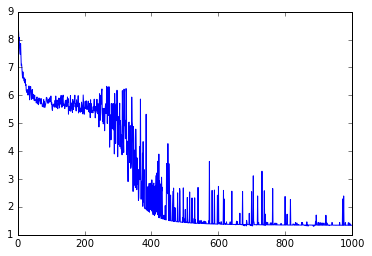

In [6]:
plt.plot(ES)

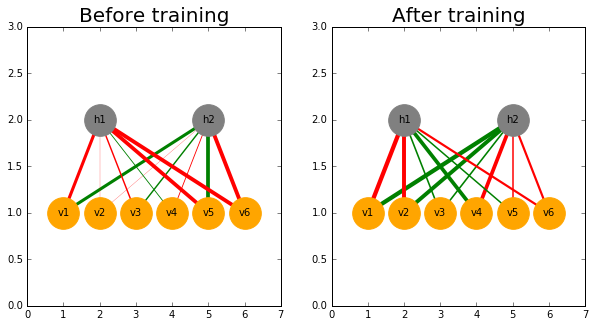

In [7]:
name={0:'v1',1:'v2',2:'v3',3:'v4',4:'v5',5:'v6',6:'h1',7:'h2'}
pos={'v1':(1,1),'v2':(2,1),'v3':(3,1),'v4':(4,1),'v5':(5,1),'v6':(6,1),
     'h1':(2,2),'h2':(5,2)}
cmap = cm.get_cmap('Accent',8)
#
fig = plt.figure(figsize=(10, 5),facecolor='white')
ax = fig.add_subplot(121)
for k in range(8):
    label = name[k]
    xk,yk=pos[label]
    #plt.scatter(xk,yk,s=1000,color=cmap(k),zorder=2)
    if k<6:
        plt.scatter(xk,yk,s=1000,color='orange',zorder=2)
    else:
        plt.scatter(xk,yk,s=1000,color='gray',zorder=2)
    plt.text(xk,yk,label,ha='center',va='center',zorder=3)
ws=W1[1:,1:]
for n in range(6):
    i,j=ws[n]
    xv,yv=pos[name[n]]
    xh1,yh1=pos['h1']
    xh2,yh2=pos['h2']
    if i > 0:
        ci='g'
    else:
        ci='r'
    if j>0:
        cj='g'
    else:
        cj='r'
    plt.plot([xv,xh1],[yv,yh1],color=ci,linewidth=np.abs(i)*50+0.2,zorder=1)
    plt.plot([xv,xh2],[yv,yh2],color=cj,linewidth=np.abs(i)*50+0.2,zorder=1)
plt.xlim(0,7)
plt.ylim(0,3)
plt.title('Before training',size=20)
#
ax = fig.add_subplot(122)
for k in range(8):
    label = name[k]
    xk,yk=pos[label]
    #plt.scatter(xk,yk,s=1000,color=cmap(k),zorder=2)
    if k<6:
        plt.scatter(xk,yk,s=1000,color='orange',zorder=2)
    else:
        plt.scatter(xk,yk,s=1000,color='gray',zorder=2)
    plt.text(xk,yk,label,ha='center',va='center',zorder=3)
ws=W[1:,1:]
for n in range(6):
    i,j=ws[n]
    xv,yv=pos[name[n]]
    xh1,yh1=pos['h1']
    xh2,yh2=pos['h2']
    if i > 0:
        ci='g'
    else:
        ci='r'
    if j>0:
        cj='g'
    else:
        cj='r'
    plt.plot([xv,xh1],[yv,yh1],color=ci,linewidth=np.abs(i)+0.2,zorder=1)
    plt.plot([xv,xh2],[yv,yh2],color=cj,linewidth=np.abs(i)+0.2,zorder=1)
plt.xlim(0,7)
plt.ylim(0,3)
plt.title('After training',size=20)

In [19]:
# Daydream

num_samples = 100
samples = np.ones((num_samples, n_v + 1))
samples[0,1:] = np.random.rand(n_v)
for i in range(1, num_samples):
    visible = samples[i-1,:]
    h_a = np.dot(visible, W) # hidden node sum weight 
    h_p = logistic(h_a) # hidden node activate probability
    h_s = h_p > np.random.rand(n_h + 1)  # hidden node state
    h_s[0] = 1 # fix the bias activate probability to 1.
    # negative phase
    v_a = np.dot(h_s, W.T) # visible node sum weight
    v_p = logistic(v_a) # visible node activate probability
    v_s = v_p > np.random.rand(n_v + 1)  # visible node state
    samples[i,:] = v_s


(0, 1.4)

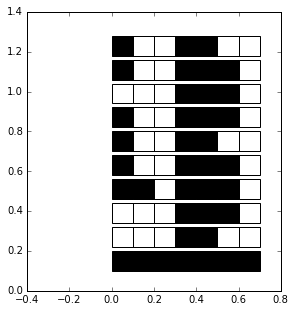

In [30]:

# visualize data
fig = plt.figure(figsize=(10, 5),facecolor='white')
ax = fig.add_subplot(121)
for i in range(10):
    for j in range(samples.shape[1]):
        centerX,centerY=(j * 0.1, 0.1+i/10.0+i*0.02)
        width,height=(0.1,0.1)
        if samples[i][j]==0:
                   f=False
        else:
                   f=True
        ax.add_patch(patches.Rectangle((centerX,centerY),width,height,fill=f,facecolor='k'))
plt.xlim(-0.4,0.8)
plt.ylim(0,1.4)